### What is this notebook for? ###

The main purpose of this notebook is buiding Liquidity's probability model for the Imovirtual, category "apartments for sell".

**Prerequisities:** "ml_dataset_imovirtual.tsv". Can be obtained with `2.QualityDriversDataPrepImovirtual-Jun-Dec.ipynb`

**Output:**

* Stored model: `xgb_imo_buy_02.pkl`
* Average price for city/rooms_num: `avg_city_price_imo_buy_02.csv`
* Model columns name: `model_columns_xgb_imo_buy_02.pkl`

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import  train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, classification_report

from xgboost.sklearn import XGBClassifier
from sklearn.externals import joblib

import matplotlib.pyplot as plt
%matplotlib inline

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
dataset_full = pd.read_csv("ml_dataset_imovirtual.tsv", sep ="\t")

Select only listings in category 101, apartments for sell.

In [4]:
dataset_full = dataset_full[dataset_full['category_id'] == 101]

We will train our model on Jun-Nov data:

In [5]:
train_full = dataset_full[dataset_full['month'] !=12]

Data validation on December data:

In [6]:
cv_full =  dataset_full[dataset_full['month'] == 12]

In [7]:
#cv_full['n_images2'] = cv_full['n_images']

In [8]:
def create_liquid_field(dataframe):
    dataframe['unique_senders'] = dataframe['unique_senders'].fillna(0).astype('int')
    dataframe['liquid'] = (dataframe['unique_senders'] >= 3).astype('int')
    return dataframe

In [9]:
def select_category(dataframe, category_id):
    dataframe = dataframe[dataframe['category_id'] == category_id]
    return dataframe

In [10]:
def select_columns(dataframe, columns):
    dataframe = dataframe[columns]
    return dataframe

In [11]:
columns =  ['ad_id',
            'city_id', 
            'title', 
            'description', 
            'private_business',
            'n_images2',
            'was_paid_for_post', 
            'is_paid_for_post', 
            'street_name',
            'mysql_search_m', 
            'mysql_search_price',
            'rooms_num', 
            'bathrooms_num',
            'condition', 
            'construction_year',
            'energy_certificate', 
            'negotiable',
            'exchange', 
            'unique_senders']

In [12]:
def filter_values(dataframe, col, values_list):
    dataframe = dataframe[dataframe[col].isin(values_list)]
    return dataframe

In [13]:
def remove_outliers(dataframe, col, lower_bound, upper_bound):
    dataframe = dataframe[(dataframe[col] >= lower_bound) & (dataframe[col] <= upper_bound)]
    return dataframe

In [14]:
def add_avg_price_city_ap_type(dataframe):
    city_n = pd.DataFrame({'city_n': dataframe.groupby(['city_id'])['ad_id'].nunique()}).reset_index()
    city_room_avg_price = pd.DataFrame({'avg_price': dataframe.groupby(['city_id', 'rooms_num'])['mysql_search_price'].mean()}).reset_index()
    dataframe = dataframe.merge(city_n, on='city_id', how='left')
    dataframe = dataframe.merge(city_room_avg_price, on = ['city_id', 'rooms_num'], how='left')
    #dataframe = dataframe[dataframe["city_n"] >= 30]
    return dataframe

In [15]:
def count_avg_price_city_ap_type(dataframe):
    city_n = pd.DataFrame({'city_n': dataframe.groupby(['city_id'])['ad_id'].nunique()}).reset_index()
    city_room_avg_price = pd.DataFrame({'avg_price': dataframe.groupby(['city_id', 'rooms_num'])['mysql_search_price'].mean()}).reset_index()
    return city_room_avg_price

In [16]:
def add_higher_city_room_avg(dataframe):
    dataframe['higher_city_room_mean'] = (dataframe['mysql_search_price'] > dataframe['avg_price']).astype('int')
    return dataframe

In [17]:
def private_business_binarization(dataframe):
    dataframe.private_business = dataframe.private_business.replace({'private': 1, 'business':0})
    dataframe.private_business = dataframe.private_business.fillna('no_info')
    return dataframe

In [18]:
def column_info(dataframe, col, new_column_name, drop=False):
    dataframe[new_column_name] = pd.notnull(dataframe[col]).astype('int')
    if drop:
        dataframe = dataframe.drop(col, axis=1)
    return dataframe

In [19]:
def create_construction_decade(dataframe):
    dataframe['construction_year'] = dataframe['construction_year'].replace('no', 0).astype('float')
    dataframe['construction_year_decade'] = dataframe['construction_year'].fillna(0)\
    .apply(lambda year: year if (year > 1000 and year < 2030) else 'no_info')\
    .apply(lambda year: str(year)[0:3]+'0')
    dataframe = dataframe.drop('construction_year', axis=1)
    return dataframe

In [20]:
def create_avg_price_diff(dataframe, avg_price_col, price_col, new_column_name):
    dataframe[new_column_name] = (dataframe[price_col] - dataframe[avg_price_col])/dataframe[avg_price_col]
    return dataframe

#### Category dict

* 101 - apartments to buy
* 102 - apartments to rent

In [21]:
imo_train_buy = train_full.pipe(select_category, category_id = 101)\
.pipe(select_columns, columns=columns)\
.pipe(create_liquid_field)\
.pipe(remove_outliers, col='mysql_search_price', lower_bound=20000, upper_bound=400000)\
.pipe(filter_values, col='rooms_num', values_list=['0', '1', '2', '3', '4', '5', '6'])\
.pipe(remove_outliers, col='mysql_search_m', lower_bound=20, upper_bound=200)\
.pipe(add_avg_price_city_ap_type)\
.pipe(add_higher_city_room_avg)\
.pipe(private_business_binarization)\
.pipe(column_info, col='construction_year', new_column_name='construction_year_info')\
.pipe(column_info, col='energy_certificate', new_column_name='energy_certificate')\
.pipe(column_info, col='bathrooms_num', new_column_name='bathrooms_info')\
.pipe(column_info, col='condition', new_column_name='condition_info')\
.pipe(create_construction_decade)\
.pipe(column_info, col='street_name', new_column_name='street_info', drop=True)\
.pipe(create_avg_price_diff, avg_price_col='avg_price', price_col='mysql_search_price', new_column_name= 'price_diff')

In [22]:
imo_cv_buy = cv_full.pipe(select_category, category_id = 101)\
.pipe(select_columns, columns=columns)\
.pipe(create_liquid_field)\
.pipe(remove_outliers, col='mysql_search_price', lower_bound=20000, upper_bound=400000)\
.pipe(filter_values, col='rooms_num', values_list=['0', '1', '2', '3', '4', '5', '6'])\
.pipe(remove_outliers, col='mysql_search_m', lower_bound=20, upper_bound=200)\
.pipe(add_avg_price_city_ap_type)\
.pipe(add_higher_city_room_avg)\
.pipe(private_business_binarization)\
.pipe(column_info, col='construction_year', new_column_name='construction_year_info')\
.pipe(column_info, col='energy_certificate', new_column_name='energy_certificate')\
.pipe(column_info, col='bathrooms_num', new_column_name='bathrooms_info')\
.pipe(column_info, col='condition', new_column_name='condition_info')\
.pipe(create_construction_decade)\
.pipe(column_info, col='street_name', new_column_name='street_info', drop=True)\
.pipe(create_avg_price_diff, avg_price_col='avg_price', price_col='mysql_search_price', new_column_name= 'price_diff')

In [23]:
imo_train_buy.columns

Index(['ad_id', 'city_id', 'title', 'description', 'private_business',
       'n_images2', 'was_paid_for_post', 'is_paid_for_post', 'mysql_search_m',
       'mysql_search_price', 'rooms_num', 'bathrooms_num', 'condition',
       'energy_certificate', 'negotiable', 'exchange', 'unique_senders',
       'liquid', 'city_n', 'avg_price', 'higher_city_room_mean',
       'construction_year_info', 'bathrooms_info', 'condition_info',
       'construction_year_decade', 'street_info', 'price_diff'],
      dtype='object')

In [24]:
cat_columns = ['energy_certificate',
               'rooms_num',
               'bathrooms_num',
               'condition',
               'energy_certificate', 
               'negotiable',
               'exchange',
               'construction_year_decade']

In [25]:
num_columns = ['title', 
               'description', 
               'mysql_search_m', 
               'mysql_search_price', 
               'n_images2', 
               'avg_price',
              'price_diff']

In [26]:
imo_train_buy.columns

Index(['ad_id', 'city_id', 'title', 'description', 'private_business',
       'n_images2', 'was_paid_for_post', 'is_paid_for_post', 'mysql_search_m',
       'mysql_search_price', 'rooms_num', 'bathrooms_num', 'condition',
       'energy_certificate', 'negotiable', 'exchange', 'unique_senders',
       'liquid', 'city_n', 'avg_price', 'higher_city_room_mean',
       'construction_year_info', 'bathrooms_info', 'condition_info',
       'construction_year_decade', 'street_info', 'price_diff'],
      dtype='object')

In [27]:
train_columns = ['city_id', 
                 'title', 
                 'description', 
                 'private_business',
                 'n_images2', 
                 'was_paid_for_post', 
                 'is_paid_for_post', 
                 'mysql_search_m',
                 'mysql_search_price', 
                 'rooms_num',
                 'bathrooms_num', 
                 'condition', 
                 'energy_certificate', 
                 'negotiable',
                 'exchange',  
                 'avg_price',
                 'higher_city_room_mean', 
                 'construction_year_info', 
                 'bathrooms_info',
                 'condition_info', 
                 'construction_year_decade', 
                 'street_info',
                 'price_diff',
                 'liquid']

In [28]:
imo_train_buy = imo_train_buy[train_columns]

In [29]:
imo_cv_buy = imo_cv_buy[train_columns]

In [30]:
imo_train_buy[cat_columns] = imo_train_buy[cat_columns].fillna('no_info')
imo_cv_buy[cat_columns] = imo_cv_buy[cat_columns].fillna('no_info')

In [31]:
imo_train_buy[cat_columns] = imo_train_buy[cat_columns].astype('str')
imo_cv_buy[cat_columns] = imo_cv_buy[cat_columns].astype('str')

In [32]:
imo_train_buy[num_columns] = imo_train_buy[num_columns].fillna(0)
imo_cv_buy[num_columns] = imo_cv_buy[num_columns].fillna(0)

In [33]:
train_dataset = pd.get_dummies(imo_train_buy)
test_dataset = pd.get_dummies(imo_cv_buy)

In [34]:
train_dataset.shape

(105527, 72)

In [35]:
y = train_dataset['liquid']
y_cv = test_dataset['liquid']

In [36]:
X = train_dataset.drop('liquid', axis=1)
X_cv = test_dataset.drop('liquid', axis=1)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=432)

In [38]:
ratio = float(np.sum(y == 0)) / np.sum(y == 1)
ratio

7.029140987597961

In [39]:
default_params = {
    'objective': 'binary:logistic',
    'max_depth':7,
    'learning_rate': 0.1,
    'silent': False,
    'min_child_weight': 7,
    'subsample': 0.8, 
    'colsample_bytree': 0.8,
    'scale_pos_weight': ratio,
    'n_estimators': 2500
}


In [40]:
clf = XGBClassifier(**default_params)

In [41]:
clf.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)], 
        eval_metric='logloss', 
        verbose=False, early_stopping_rounds=10)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=7, missing=None, n_estimators=2500, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=7.029140987597961, seed=0, silent=False,
       subsample=0.8)

In [42]:
from sklearn.externals import joblib
joblib.dump(clf, 'xgb_imo_buy_02.pkl') 

['xgb_imo_buy_02.pkl']

In [43]:
def my_plot_importance(booster, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)

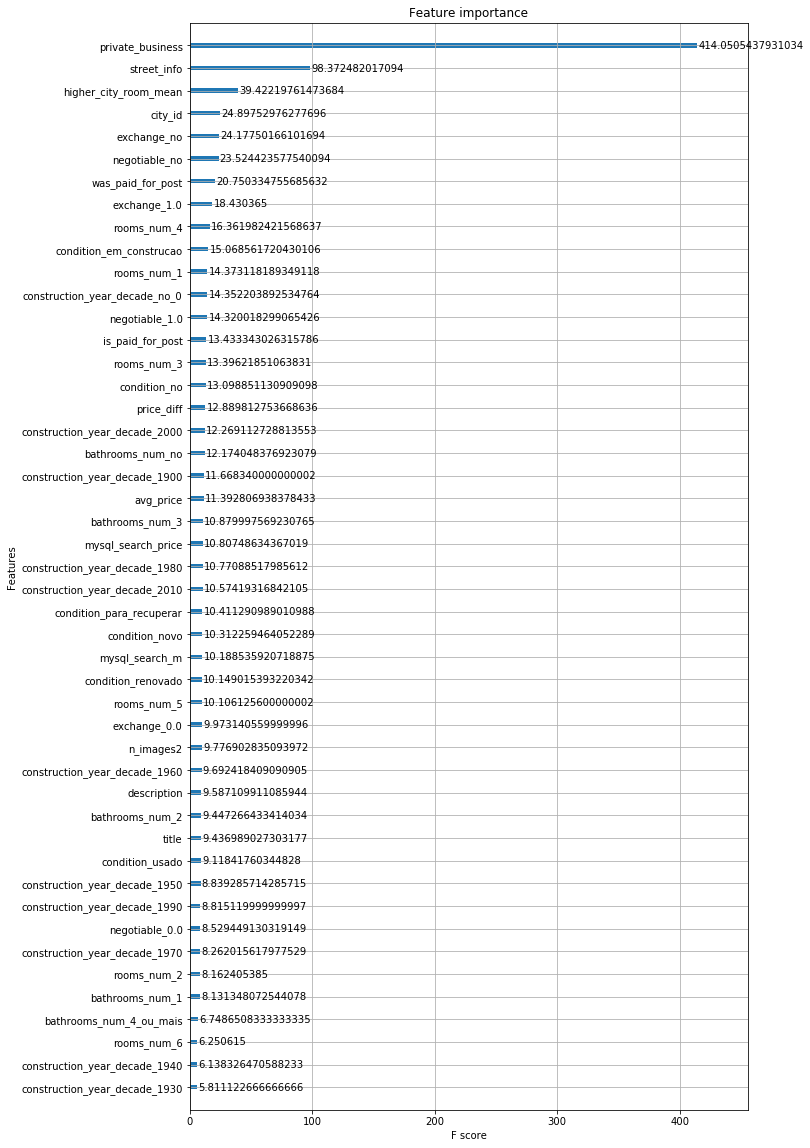

In [44]:
my_plot_importance(clf, figsize=(10, 20),  importance_type='gain' )

**Validation on train:**

In [45]:
y_train_predict = clf.predict(X_train)

In [46]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_train, y_train_predict)))
print('Precision: {0:.2f}'.format(precision_score(y_train, y_train_predict)))
print('Recall: {0:.2f}'.format(recall_score(y_train, y_train_predict)))
print('F1: {0:.2f}'.format(f1_score(y_train, y_train_predict)))

Accuracy: 0.94
Precision: 0.69
Recall: 0.98
F1: 0.81


In [47]:
pd.crosstab(
    pd.Series(y_train, name='Actual'),
    pd.Series(y_train_predict, name='Predicted'),
    margins=True
)

Predicted,0.0,1.0,All
Actual,,,
0.0,42253,9034,51287
1.0,6649,1423,8072
All,48902,10457,59359


In [48]:
print(classification_report(y_train, y_train_predict))

             precision    recall  f1-score   support

          0       1.00      0.94      0.97     69376
          1       0.69      0.98      0.81      9769

avg / total       0.96      0.94      0.95     79145



**Validation on test:**

In [49]:
y_val_predict = clf.predict(X_test)

In [50]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_val_predict)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_val_predict)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_val_predict)))
print('F1: {0:.2f}'.format(f1_score(y_test, y_val_predict)))

Accuracy: 0.86
Precision: 0.46
Recall: 0.59
F1: 0.52


In [51]:
pd.crosstab(
    pd.Series(y_test, name='Actual'),
    pd.Series(y_val_predict, name='Predicted'),
    margins=True
)

Predicted,0.0,1.0,All
Actual,,,
0.0,4350,915,5265
1.0,1066,217,1283
All,5416,1132,6548


In [52]:
print(classification_report(y_test, y_val_predict))

             precision    recall  f1-score   support

          0       0.94      0.90      0.92     23008
          1       0.46      0.59      0.52      3374

avg / total       0.88      0.86      0.87     26382



**Validation on December data:**

In [53]:
for col in X.columns:
    if col not in X_cv.columns:
        print(col)
        X_cv[col] = 0

rooms_num_0
construction_year_decade_1070
construction_year_decade_1190
construction_year_decade_1230
construction_year_decade_1300
construction_year_decade_1370
construction_year_decade_1660
construction_year_decade_1670
construction_year_decade_1690
construction_year_decade_1700
construction_year_decade_1800
construction_year_decade_1820
construction_year_decade_1850
construction_year_decade_1860
construction_year_decade_2020


In [54]:
for col in X_cv.columns:
    if col not in X.columns:
        print(col)
        X_cv = X_cv.drop(col, axis=1)

construction_year_decade_1010
construction_year_decade_1080


In [55]:
selected_columns = X.columns 

In [56]:
y_cv_predict = clf.predict(X_cv[selected_columns])

In [57]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_cv, y_cv_predict)))
print('Precision: {0:.2f}'.format(precision_score(y_cv,  y_cv_predict)))
print('Recall: {0:.2f}'.format(recall_score(y_cv, y_cv_predict)))
print('F1: {0:.2f}'.format(f1_score(y_cv,  y_cv_predict)))

Accuracy: 0.86
Precision: 0.37
Recall: 0.53
F1: 0.43


In [58]:
pd.crosstab(
    pd.Series(y_cv, name='Actual'),
    pd.Series(y_cv_predict, name='Predicted'),
    margins=True
)

Predicted,0,1,All
Actual,,,
0,10711,1244,11955
1,654,724,1378
All,11365,1968,13333


In [59]:
print(classification_report(y_cv, y_cv_predict))

             precision    recall  f1-score   support

          0       0.94      0.90      0.92     11955
          1       0.37      0.53      0.43      1378

avg / total       0.88      0.86      0.87     13333



In [60]:
from eli5 import show_weights
show_weights(clf)

Weight,Feature
0.3850,private_business
0.0915,street_info
0.0367,higher_city_room_mean
0.0232,city_id
0.0225,exchange_no
0.0219,negotiable_no
0.0193,was_paid_for_post
0.0171,exchange_1.0
0.0152,rooms_num_4
0.0140,condition_em_construcao


For usage model as a service we need to store:

* average price for city_id/rooms_num combination
* model columns 
* model

**Average price for city_id/rooms_num combination**

In [61]:
avg_city = dataset_full.pipe(select_category, category_id = 101)\
.pipe(remove_outliers, col='mysql_search_price', lower_bound=20000, upper_bound=400000)\
.pipe(filter_values, col='rooms_num', values_list=['0', '1', '2', '3', '4', '5', '6'])\
.pipe(remove_outliers, col='mysql_search_m', lower_bound=20, upper_bound=200)\
.pipe(count_avg_price_city_ap_type)

In [62]:
avg_city[avg_city['city_id'] == 11539464]

,city_id,rooms_num,avg_price
1242,11539464,1,213263.751092
1243,11539464,2,235866.077170
1244,11539464,3,255477.101504
1245,11539464,4,304052.631579
1246,11539464,5,295000.000000


In [63]:
avg_city.rooms_num = avg_city.rooms_num.astype('int')

In [64]:
avg_city.to_csv("avg_city_price_imo_buy_02.csv", index=None)

**Save model columns**

In [65]:
model_columns = list(X_train.columns)
joblib.dump(model_columns, 'model_columns_xgb_imo_buy_02.pkl')

['model_columns_xgb_imo_buy_02.pkl']

### Example how it works as a service ###

Input example:

In [66]:
data = {
        "city_id": 11539464,
        "title": 30,
        "description": 1000,
        "private_business": "private",
        "street_name" : "Vodickova",
        "rooms_num": 2,
        "mysql_search_m": 80,
        "mysql_search_price": 200000,
        "mysql_search_price_per_m": 2500,
        "construction_year": 1998,
    }

We transform json data to pandas dataframe:

In [67]:
def get_dataframe(json):
    df = pd.DataFrame.from_dict([dict(json)])
    return df

In [68]:
t1 = get_dataframe(data)

In [69]:
t1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 10 columns):
city_id                     1 non-null int64
construction_year           1 non-null int64
description                 1 non-null int64
mysql_search_m              1 non-null int64
mysql_search_price          1 non-null int64
mysql_search_price_per_m    1 non-null int64
private_business            1 non-null object
rooms_num                   1 non-null int64
street_name                 1 non-null object
title                       1 non-null int64
dtypes: int64(8), object(2)
memory usage: 160.0+ bytes


Add average price for this city_id and rooms_num

In [70]:
t1 = t1.merge(avg_city, on= ['city_id', 'rooms_num'])

In [71]:
model_columns = ['city_id', 
                 'title', 
                 'description', 
                 'private_business',
                 'n_images2', 
                 'was_paid_for_post', 
                 'is_paid_for_post', 
                 'mysql_search_m',
                 'mysql_search_price', 
                 'mysql_search_price_per_m', 
                 'rooms_num',
                 'bathrooms_num', 
                 'condition', 
                 'energy_certificate', 
                 'construction_year',
                 'negotiable',
                 'exchange',  
                 'avg_price',
                 'higher_city_room_mean', 
                 'construction_year']

In [72]:
for col in model_columns:
    if col not in t1.columns:
        print(col)
        t1[col] = None

n_images2
was_paid_for_post
is_paid_for_post
bathrooms_num
condition
energy_certificate
negotiable
exchange
higher_city_room_mean


In [73]:
t1

,city_id,construction_year,description,mysql_search_m,mysql_search_price,mysql_search_price_per_m,private_business,rooms_num,street_name,title,avg_price,n_images2,was_paid_for_post,is_paid_for_post,bathrooms_num,condition,energy_certificate,negotiable,exchange,higher_city_room_mean
0,11539464,1998,1000,80,200000,2500,private,2,Vodickova,30,235866.07717,None,None,None,None,None,None,None,None,None


In [74]:
f2 = t1\
.pipe(add_higher_city_room_avg)\
.pipe(private_business_binarization)\
.pipe(column_info, col='construction_year', new_column_name='construction_year_info')\
.pipe(create_construction_decade)\
.pipe(column_info, col='street_name', new_column_name='street_info', drop=True)\
.pipe(column_info, col='energy_certificate', new_column_name='energy_certificate')\
.pipe(column_info, col='bathrooms_num', new_column_name='bathrooms_info')\
.pipe(column_info, col='condition', new_column_name='condition_info')\
.pipe(create_avg_price_diff, avg_price_col='avg_price', price_col='mysql_search_price', new_column_name= 'price_diff')

In [75]:
f2

,city_id,description,mysql_search_m,mysql_search_price,mysql_search_price_per_m,private_business,rooms_num,title,avg_price,n_images2,...,energy_certificate,negotiable,exchange,higher_city_room_mean,construction_year_info,construction_year_decade,street_info,bathrooms_info,condition_info,price_diff
0,11539464,1000,80,200000,2500,1,2,30,235866.07717,None,...,0,None,None,0,1,1990,1,0,0,-0.152061


In [76]:
f2[num_columns] = f2[num_columns].fillna(0)

In [77]:
f2[cat_columns] = f2[cat_columns].fillna('no_info').astype('str')

In [78]:
f2 = pd.get_dummies(f2)

In [79]:
f2

,city_id,description,mysql_search_m,mysql_search_price,mysql_search_price_per_m,private_business,title,avg_price,n_images2,higher_city_room_mean,...,bathrooms_info,condition_info,price_diff,rooms_num_2,bathrooms_num_no_info,condition_no_info,energy_certificate_0,negotiable_no_info,exchange_no_info,construction_year_decade_1990
0,11539464,1000,80,200000,2500,1,30,235866.07717,0,0,...,0,0,-0.152061,1,1,1,1,1,1,1


In [80]:
for col in X_train.columns:
    if col not in f2.columns:
        f2[col] = 0

In [81]:
sel_cols = X_train.columns

In [82]:
f2 = f2[sel_cols]

In [83]:
clf.predict_proba(f2)

array([[0.09547728, 0.9045227 ]], dtype=float32)

In [84]:
from eli5 import show_prediction
show_prediction(clf, f2.iloc[0], show_feature_values=True, top=10)